<a href="https://colab.research.google.com/github/AmeerAliSaleem/MA4J5_Project/blob/main/Ameer_Ali_Saleem_MA4J5_Model_building_first_attempt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MA4J5 Project: Predicting Amazon Review Scores with neural networks (Model 1)
---
### Ameer Ali Saleem

A Python notebook containing the Python code to support my MA4J5 report. Please note that this notebook has been written in Google Colab: this allows for the use of the TensorFlow package without requiring a direct installation (which would take roughly 1.1GB of storage). If you do not have TensorFlow installed, please click on the "Open in Colab" link at the top of the notebook.

# Imports and checks

In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import regex as re
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Our goal is to build a neural network to predict the rating (out of 5 stars) of an input Amazon Kindle review. The data used in this project can be found at <a href="https://nijianmo.github.io/amazon/index.html">this link</a>. Due to the sheer quantity of data, I have chosen to use just 10% of the 5-core Kindle Store data. We begin by importing and cleaning the data:

In [2]:
df = pd.read_csv("kindle_cleaned.csv")

In [3]:
df.head()

,Unnamed: 0,overall,reviewTime,reviewText,summary
0,0,5.0,"01 24, 2015",Great Classic for free. only wish they had th...,Five Stars
1,1,4.0,"05 16, 2013","I liked it, wished for more about her grandpar...",Pretty good
2,2,5.0,"01 2, 2013","I really liked this short story, but I really ...",Wished it was longer...
3,3,5.0,"03 23, 2016",Wow I love this series,Five Stars
4,4,5.0,"09 19, 2015",Great series. Can't wait to read more. Love t...,Love it


In [4]:
df = df.drop(columns="Unnamed: 0")

In [5]:
df.head()

,overall,reviewTime,reviewText,summary
0,5.0,"01 24, 2015",Great Classic for free. only wish they had th...,Five Stars
1,4.0,"05 16, 2013","I liked it, wished for more about her grandpar...",Pretty good
2,5.0,"01 2, 2013","I really liked this short story, but I really ...",Wished it was longer...
3,5.0,"03 23, 2016",Wow I love this series,Five Stars
4,5.0,"09 19, 2015",Great series. Can't wait to read more. Love t...,Love it


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 141992 entries, 0 to 141991
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   overall     141992 non-null  float64
 1   reviewTime  141992 non-null  object 
 2   reviewText  141961 non-null  object 
 3   summary     141895 non-null  object 
dtypes: float64(1), object(3)
memory usage: 4.3+ MB


# Text Preprocessing

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 141992 entries, 0 to 141991
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   overall     141992 non-null  float64
 1   reviewTime  141992 non-null  object 
 2   reviewText  141961 non-null  object 
 3   summary     141895 non-null  object 
dtypes: float64(1), object(3)
memory usage: 4.3+ MB


In [9]:
type(df["reviewText"].values)

numpy.ndarray

In [10]:
print(type(df["reviewText"].iloc[0]))

<class 'str'>


In [11]:
df["reviewText"] = df["reviewText"].astype(str)

In [12]:
stopwords = nltk.corpus.stopwords.words('english')
print(stopwords)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [13]:
reviews_cleaned = []

for i in range(len(df["reviewText"])):
  reviews_raw = df["reviewText"].iloc[i]
  reviews_edit_1 = reviews_raw.lower()
  reviews_edit_2 = re.sub(r"[^a-zA-Z0-9\s\.]", "", reviews_edit_1) # Filter punctuation
  # reviews_edit_3 = re.sub(" \.|\. ", "", reviews_edit_2) # Get rid of fullstops that are outside of words
  reviews_cleaned.append(reviews_edit_2.strip()) # remove unnecessary whitespace and append to list of cleaned reviews

In [14]:
# remove stopwords from the cleaned list
filtered_reviews = [
    ' '.join(word for word in sentence.split() if word.lower() not in stopwords)
    for sentence in reviews_cleaned
]

In [15]:
# take a look at some sample data
reviews_cleaned[:5]

['great classic for free.  only wish they had the whole pepper set',
 'i liked it wished for more about her grandparents n his family history but it was enough. enjoy the read',
 'i really liked this short story but i really do wish it was longer. it was like reading a book and getting to the end and the rest of the book is missing. it left me wanting more and to me personally that means it was a very good story. i have several of stephen king s books and this story is now one of my favorites. i would recommend it to everyone',
 'wow i love this series',
 'great series. cant wait to read more.  love the family and the terrific group of amazing characters.  already bought the rest.  cant wait to read them']

In [16]:
# compare the above with stopwords removed
filtered_reviews[:5]

['great classic free. wish whole pepper set',
 'liked wished grandparents n family history enough. enjoy read',
 'really liked short story really wish longer. like reading book getting end rest book missing. left wanting personally means good story. several stephen king books story one favorites. would recommend everyone',
 'wow love series',
 'great series. cant wait read more. love family terrific group amazing characters. already bought rest. cant wait read']

## Train-test split

In [17]:
labels = list(df["overall"])

# Shuffle the data.

filtered_reviews, labels = zip(*random.sample(list(zip(filtered_reviews,labels)), len(filtered_reviews)))
filtered_reviews = list(filtered_reviews)
labels = list(labels)

# Train-test split (80:20)

trainsize = int(len(filtered_reviews)*0.8)

train_reviews, train_labels = filtered_reviews[:trainsize], labels[:trainsize]
test_reviews, test_labels = filtered_reviews[trainsize:], labels[trainsize:]

In [18]:
# Check distribution reviews (1,2,3,4,5) in the training set

print("TRAINING SET")
print("Number of reviews to use for training is: {}.".format(len(train_labels)))
print("Number of 5-star reviews is: {} (or {:.1f}%).".format(sum(np.array(train_labels)==5),100*sum(np.array(train_labels)==5)/len(train_labels)))
print("Number of 4-star reviews is: {} (or {:.1f}%).".format(sum(np.array(train_labels)==4),100*sum(np.array(train_labels)==4)/len(train_labels)))
print("Number of 3-star reviews is: {} (or {:.1f}%).".format(sum(np.array(train_labels)==3),100*sum(np.array(train_labels)==3)/len(train_labels)))
print("Number of 2-star reviews is: {} (or {:.1f}%).".format(sum(np.array(train_labels)==2),100*sum(np.array(train_labels)==2)/len(train_labels)))
print("Number of 1-star reviews is: {} (or {:.1f}%).".format(sum(np.array(train_labels)==1),100*sum(np.array(train_labels)==1)/len(train_labels)))

TRAINING SET
Number of reviews to use for training is: 113593.
Number of 5-star reviews is: 69153 (or 60.9%).
Number of 4-star reviews is: 26791 (or 23.6%).
Number of 3-star reviews is: 10836 (or 9.5%).
Number of 2-star reviews is: 3885 (or 3.4%).
Number of 1-star reviews is: 2928 (or 2.6%).


## Tokenisation

The word tokenizer provided by the Keras package will be able to deal with full stops for us, e.g. "missing." and "missing" will be treated as the same token.

Now for the tokenisation. In particular, we must conduct this separately on the training and test sets. The reason for this is due to so-called "data leakage": we do not want to introduce any elements of the testing data to the network before or during training. These two sets should be kept as separate as possible.

In [21]:
# max size of our vectorised corpus
vocab_size = 20000

# maximum allowed length for each vectorised sentence into our neural network
# max_length = 50
max_length = 20

# Tokenization
# OOV token deals with words that our tokenizer has not seen before (e.g. in the test set)
tokenizer = Tokenizer(num_words = vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(train_reviews)
word_index = tokenizer.word_index

# print out our dictionary of vectors
# print(word_index)


train_sequences = tokenizer.texts_to_sequences(train_reviews)
test_sequences = tokenizer.texts_to_sequences(test_reviews)

# padding sequences to standardise the input size of each row of data for our NN
train_padded = pad_sequences(train_sequences, maxlen=max_length)
test_padded = pad_sequences(test_sequences, maxlen=max_length)

In [20]:
print(len(word_index))

90467


# Model Building and Evaluation

We now experiment with a variety of neural network architectures, with the aim of maximising the accuracy of our model on the *testing set*.

In [22]:
# more model parameters
embedding_dim = 16
num_epochs = 15

In [29]:
model1 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
])
model1.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [30]:
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 20, 16)            320000    
                                                                 
 global_average_pooling1d (  (None, 16)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense_2 (Dense)             (None, 24)                408       
                                                                 
 dense_3 (Dense)             (None, 5)                 125       
                                                                 
Total params: 320533 (1.22 MB)
Trainable params: 320533 (1.22 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [32]:
train_labels_int = [int(x) for x in train_labels]
test_labels_int = [int(x) for x in test_labels]

In [34]:
history = model1.fit(train_padded, tf.one_hot(train_labels_int,5), epochs=num_epochs, validation_data=(test_padded, tf.one_hot(test_labels_int,5)), verbose=2)

Epoch 1/15
3550/3550 - 23s - loss: 0.4480 - accuracy: 0.2223 - val_loss: 0.4406 - val_accuracy: 0.2350 - 23s/epoch - 6ms/step
Epoch 2/15
3550/3550 - 20s - loss: 0.5266 - accuracy: 0.1785 - val_loss: 0.8390 - val_accuracy: 0.0250 - 20s/epoch - 6ms/step
Epoch 3/15
3550/3550 - 22s - loss: 1.0093 - accuracy: 0.1719 - val_loss: 0.6157 - val_accuracy: 0.1173 - 22s/epoch - 6ms/step
Epoch 4/15
3550/3550 - 22s - loss: 2.1828 - accuracy: 0.1811 - val_loss: 3.3143 - val_accuracy: 0.0352 - 22s/epoch - 6ms/step
Epoch 5/15
3550/3550 - 27s - loss: 3.7571 - accuracy: 0.1831 - val_loss: 4.1778 - val_accuracy: 0.2348 - 27s/epoch - 8ms/step
Epoch 6/15
3550/3550 - 29s - loss: 5.8590 - accuracy: 0.1802 - val_loss: 8.6882 - val_accuracy: 0.6070 - 29s/epoch - 8ms/step
Epoch 7/15
3550/3550 - 27s - loss: 8.2548 - accuracy: 0.1795 - val_loss: 15.3437 - val_accuracy: 0.6070 - 27s/epoch - 7ms/step
Epoch 8/15
3550/3550 - 27s - loss: 9.9325 - accuracy: 0.1816 - val_loss: 8.4099 - val_accuracy: 0.2348 - 27s/epoch - 

In [35]:
def learning_curve(history):
    plt.figure(figsize=(10,12))

    # Loss subplot.
    plt.subplot(2,1,1)
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.title('Learning Curve')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()

    # Accuracy subplot.
    plt.subplot(2,1,2)
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.title('Learning Curve')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend()

    plt.show()

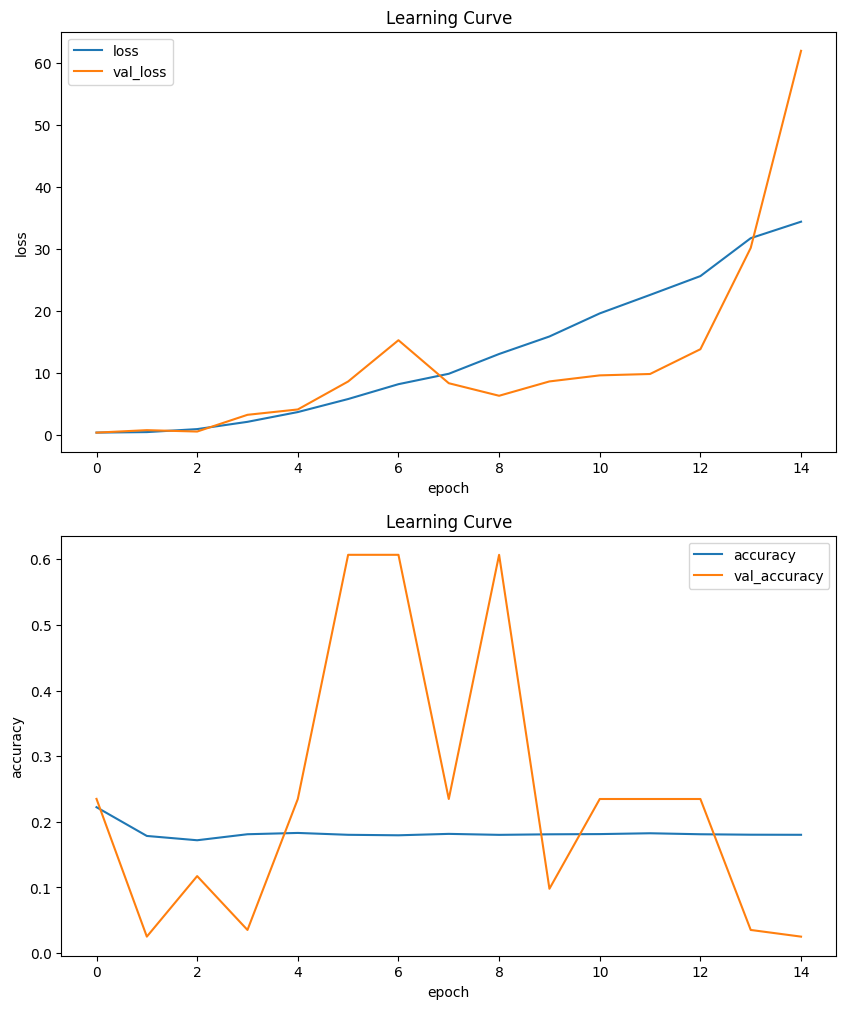

In [37]:
# plot learning curves of first model
learning_curve(history)

# Evaluation of the first model

It appears that our initial model yields a very low accuracy. This is most likely due to the extreme class imbalance present in the dataset: we have far more positive reviews that negative reviews and, as such, the model is struggling to learn the details between these two main semantics. To rectify this, we will use a technique called undersampling, in which we use fewer positive samples to provide a larger relative proportion of negative reviews.

# Model Applicaton

# Model Extensions